In [1]:
!rm -rf /kaggle/working/
!git clone https://github.com/konmue/american_dl.git

rm: cannot remove '/kaggle/working/': Device or resource busy
Cloning into 'american_dl'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 20 (delta 3), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (20/20), 3.98 KiB | 581.00 KiB/s, done.


In [2]:
import os

origin_path = "/kaggle/working"
repo_path = "/kaggle/working/american_dl"

In [3]:
os.chdir(origin_path)

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl

from tqdm import tqdm

np.set_printoptions(suppress=True)

os.chdir(repo_path)

from data.geometric_bm import geometric_bm_generator
from models.fnn import FNN
from payoffs.bermudan_max_call import bermudan_max_call

In [4]:
# Simulation params
N_SIM = 500_000
N_PRICING = 100_000
d = 5
r = 0.05
initial_value = 100
delta = 0.1
sigma = 0.2
rho = 0
K = 100
T = 3
N = 9

# NN params
input_dim = d
fc_dims = [50, 50, 50]
output_dim = 1

# Training params
learning_rates = [0.01, 0.001]
max_epochs = [1, 2]
batch_size = 8192

In [5]:
sim_paths = geometric_bm_generator(N_SIM, N, d, initial_value, delta, r, sigma, T)
sim_paths.shape

(500000, 10, 5)

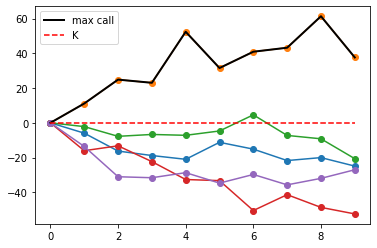

In [6]:
# plotting one sample path

max_call = np.maximum(np.amax(sim_paths[0], -1) - K, 0)

plt.plot(sim_paths[0] - K, marker='o');
plt.plot(max_call, color='k', linewidth=2, label='max call');
plt.plot(np.zeros(N+1), color='r', linestyle='dashed', label='K');
plt.legend();

In [7]:
# wrapper around payoff with fixed parameters filled in
def g(n, x):
    return bermudan_max_call(n, x, r=r, N=N, T=T, K=K)

In [8]:
# Longstaff Schwartz (Algorithm from Section 2 in paper)

models = {}

# stopping times s initialized to last period
s = (np.ones(N_SIM) * N).astype(int)

for n in np.arange(start=N-1, stop=0, step=-1):
    print(f"Training network {n}")
    
    # paths at (so far) optimal stopping time
    x_s = sim_paths[np.arange(N_SIM), s, :]
    
    # paths at point n
    x_n = sim_paths[:, n, :]
    
    # payoff at (so far) optimal stopping time; targets for the NN
    y = torch.unsqueeze(torch.Tensor(g(s, x_s)), dim=1)
    
    # setting up dataloader object for training
    dataset = TensorDataset(torch.Tensor(x_n), y)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    # defining the models; copying weights from previous model
    if n == N-1:
        model = FNN(input_dim, fc_dims, output_dim, nn.functional.mse_loss, None)
    else:
        state_dict = model.state_dict()
        model = FNN(input_dim, fc_dims, output_dim, nn.functional.mse_loss, None)
        model.load_state_dict(state_dict)
        
    # training NN based on learning rate schedule
    for learning_rate, max_epoch in zip(learning_rates, max_epochs):
        model.learning_rate = learning_rate    
        trainer = pl.Trainer(max_epochs=max_epoch)
        trainer.fit(model, dataloader)
    
    # saving the model
    models[f"model_{n}"] = model
    
    # updating optimal stopping time if stopping is larger than the approximated continuation value
    idx = g(n, x_n) >= model(torch.Tensor(x_n)).detach().numpy().squeeze()
    s[idx] = n

# value at time 0 (price) given by mean payoff at optimal stopping times    
c_0 = g(s, x_s).mean()

Training network 8


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Training network 7


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 6


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 5


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 4


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 3


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 2


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training network 1


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [9]:
pd.Series(s).describe()

count    500000.000000
mean          6.786876
std           2.214555
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max           9.000000
dtype: float64

In [10]:
pd.Series(s).value_counts()

9    180922
7     63495
8     54795
5     51341
4     49589
6     49276
3     32816
2     15384
1      2382
dtype: int64

In [11]:
# Calculating the lower pricing bound (Section 3.1 from the paper)

# New(!) set of paths
price_paths = geometric_bm_generator(N_PRICING, N, d, initial_value, delta, r, sigma, T)

# Why start at N-1 and not at N?
tau = np.ones(N_PRICING) * (N - 1)

for model in models.values():
    model.eval()

for n in tqdm(np.arange(start=N-1, stop=-1, step=-1)):
    
    x_n = price_paths[np.arange(N_PRICING), n, :]
    y = g(np.ones(N_PRICING) * n, x_n)
    
    if n == N-1:
        g_k = y.copy()
    
    if n != 0:
        c = models[f"model_{n}"](torch.Tensor(x_n)).squeeze().detach().numpy()
    else:
        c = c_0
        
    idx = y >= c
    tau[idx] = n
    g_k[idx] = y[idx]

100%|██████████| 9/9 [00:00<00:00, 17.04it/s]


In [12]:
pd.Series(tau).describe()

count    100000.000000
mean          6.418310
std           1.876614
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max           8.000000
dtype: float64

In [13]:
pd.Series(tau).value_counts()

8.0    46579
7.0    13185
5.0    10074
4.0    10047
6.0     9995
3.0     6602
2.0     3052
1.0      466
dtype: int64

In [14]:
L = g_k.mean()
sigma_L = g_k.std()
L, sigma_L

(25.364691063171215, 19.23881961044231)

In [15]:
def lower_ci_bound(L, alpha, sigma, n_pricing):
    return L - norm.ppf(alpha / 2) * sigma / (n_pricing ** 0.5)

In [16]:
lower_ci_bound(L, 0.05, sigma_L, N_PRICING)

25.48393231139077